# 数据预处理

在进行训练之前对数据集进行简单的预处理，顺便查看一下数据的基本格式

In [1]:
# 导入包
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft 
from scipy import signal


## 读取文件

基本的代码树设置如下所示：

```
PTB-XL-CLASSFIER
├── code
├── ├── dataPreprocess.ipynb
├── data
    ├── ptbxl_database.csv
    ├── scp_statements.csv
    ├── records100
    │   ├── 00000
    │   │   ├── 00001_lr.dat
    │   │   ├── 00001_lr.hea
    │   │   ├── ...
    │   │   ├── 00999_lr.dat
    │   │   └── 00999_lr.hea
    │   ├── ...
    │   └── 21000
    │        ├── 21001_lr.dat
    │        ├── 21001_lr.hea
    │        ├── ...
    │        ├── 21837_lr.dat
    │        └── 21837_lr.hea
    └── records500
    ├── 00000
    │     ├── 00001_hr.dat
    │     ├── 00001_hr.hea
    │     ├── ...
    │     ├── 00999_hr.dat
    │     └── 00999_hr.hea
    ├── ...
    └── 21000
            ├── 21001_hr.dat
            ├── 21001_hr.hea
            ├── ...
            ├── 21837_hr.dat
            └── 21837_hr.hea
```


In [2]:
# 设置读取文件路径
path = '../data/'
sampling_rate = 500

In [3]:
# 读取文件并转换标签
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [4]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [5]:
# 获取原始信号数据
X = load_raw_data(Y, sampling_rate, path)

In [6]:
# 获取scp_statements.csv中的诊断信息
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

In [7]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [8]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [9]:
# 添加诊断信息
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [10]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

## 绘图查看原始数据

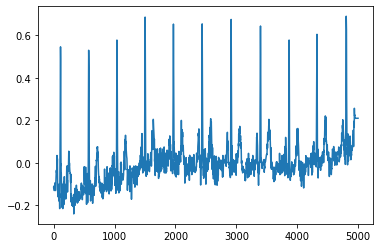

In [11]:
plt.plot(X[0][:,0])
plt.show()

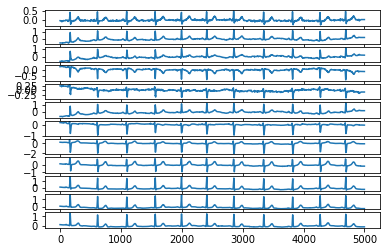

In [12]:
ecg = X[4]
plt.figure()
for index in range(12):
    plt.subplot(12,1,index+1)
    plt.plot(ecg[:,index])
plt.show()

## 心电滤波去基线漂移及分段

In [13]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

### 五点平滑滤波

In [14]:
ecg_original = X[np.random.randint(3096)][:,0]
ecg_filtered = np_move_avg(ecg_original, 5)

In [15]:
# fft变换查看频谱
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs,
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [16]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

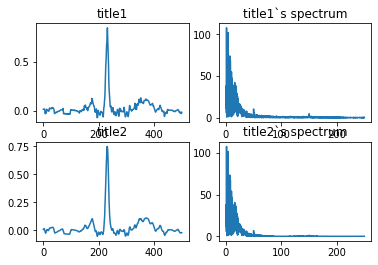

In [17]:
show_spec_dif(ecg_original, ecg_filtered)

### 陷波处理滤除工频干扰

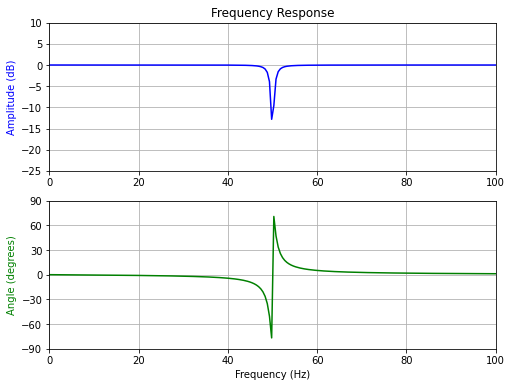

In [18]:
fs = sampling_rate  # 采样频率
f0 = 50.0   # 要去除的工频干扰
Q = 30.0    # 品质因数
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [19]:
# 工频干扰去除
ecg_notch = signal.filtfilt(b, a, ecg_filtered)

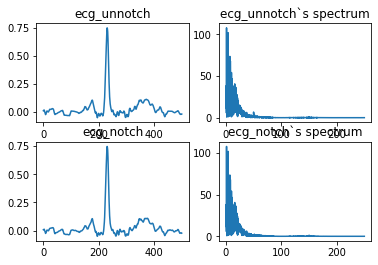

In [20]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")

In [21]:
# 去除所有导联噪声
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

## 基线漂移

利用高通滤波器去除基线漂移，基线漂移是一种低频干扰，频率范围通常小于1Hz，大部分集中在0.1Hz，通常出现在ST段和Q波附近

这里信号的采样频率为500Hz，要滤除基线漂移，通过高通滤波器得到基线漂移，然后用原信号减去基线漂移得到去基线漂移的心电信号

滤波器的设计如下：

截止频率为0.1Hz，$wn=2*0.1/1000=0.0002$

In [22]:
# b, a = signal.butter(8, 0.01, 'highpass')
# baseline = signal.filtfilt(b, a, ecg_filtered)

In [23]:
# diff = ecg_filtered-baseline
# plt.figure()
# plt.subplot(311)
# plt.plot(ecg_filtered[:1000])
# plt.subplot(312)
# plt.plot(baseline[:1000])
# plt.subplot(313)
# plt.plot(diff[:1000])
# plt.show()

>参考的论文没有去除噪声，这里没有去除噪声，尝试去除基线漂移

### 心电分段提取

根据心电12导联的$2$导联通道的R波分段，R波前的150个数据和R波之后的350个数据

In [24]:
ecg = X[np.random.randint(len(X))][:,1]

In [25]:
def get_diff(ecg):
    ecg_diff = np.zeros(len(ecg))
    for i in range(len(ecg)-1):
        ecg_diff[i] = ecg[i+1] - ecg[i]
    ecg_diff[len(ecg)-1] = ecg[len(ecg)-1]
    return ecg_diff

In [26]:
# 检测R波函数
def checkR(ecg):
    max_val = np.max(ecg)
    min_val = np.min(ecg)
    threshold_val = (max_val-min_val)*0.7 + min_val
    index = []
    for i in range(1, len(ecg)-2):
        # 满足差分阈值条件
        if ecg[i] == np.max(ecg[i-1:i+2]) and ecg[i] > threshold_val:
            # 满足心率间隔60-160
            if index != []:
                if i-index[-1] <= 60.0/60.0*sampling_rate and i-index[-1] >= 60.0/160.0*sampling_rate:
                    index.append(i)
            else:
                index.append(i)
    return np.array(index)

In [27]:
index = checkR(ecg)

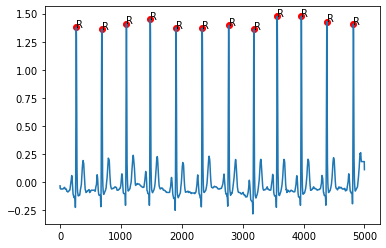

In [28]:
# 检查R波检测是否正确
plt.figure()
plt.plot(ecg)
for i in range(len(index)):
    plt.scatter(index[i], ecg[index[i]],c='r')
    plt.annotate('R',(index[i], ecg[index[i]]))
plt.show()

In [29]:
# ecg_diff = get_diff(ecg)

In [30]:
# plt.figure()
# plt.subplot(211)
# plt.plot(ecg)
# plt.subplot(212)
# plt.plot(ecg_diff)
# plt.show()

In [31]:
# 分段函数
def splitByR(ecg):
    index = checkR(ecg)              
    ecg_rhythm = None
    for i in range(len(index)):
        # 提取出一段
        if index[i]>200 and index[i]<1000-350:
            ecg_rhythm = ecg[index[i]-150:index[i]+350]
            continue
    return ecg_rhythm

In [32]:
ecg_rhythm = splitByR(ecg)

In [33]:
ecg_rhythm.size

500

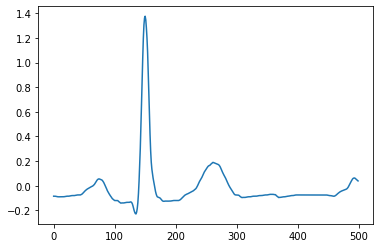

In [34]:
plt.figure()
plt.plot(ecg_rhythm)
plt.show()

In [35]:
# 对所有的信号的所有通道进行分段提取
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 500, 12])

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    R_index = checkR(X[index][:,1])
    for i in range(len(R_index)):
        # 提取出一段
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))

finish 0 in 0 s

finish 1000 in 17 s

finish 2000 in 17 s

finish 3000 in 17 s

finish 4000 in 17 s

finish 5000 in 17 s

finish 6000 in 17 s

finish 7000 in 17 s

finish 8000 in 17 s

finish 9000 in 17 s

finish 10000 in 17 s

finish 11000 in 17 s

finish 12000 in 17 s

finish 13000 in 17 s

finish 14000 in 17 s

finish 15000 in 17 s

finish 16000 in 17 s

finish 17000 in 17 s

finish 18000 in 17 s

finish 19000 in 17 s

finish 20000 in 17 s

finish 21000 in 17 s

time cost:378 s


In [36]:
ecg_rhythms.shape

(21837, 500, 12)

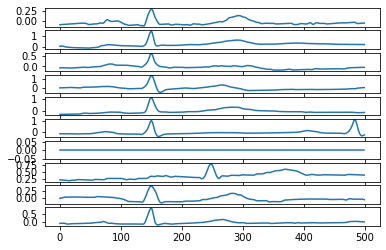

In [37]:
plt.figure()
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(ecg_rhythms[i][:,1])
plt.show()

In [38]:
false_count = 0
Y['Runconfirmed'] = 0
for index in range(len(ecg_rhythms)):
    if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
        false_count += 1
        Y['Runconfirmed'][index] = 1
false_count

2598

## 划分数据集

In [44]:
# Split data into train and test
test_fold = 10
# Train
X_train = ecg_rhythms[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)]
y_train = Y[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass
# Test
X_test = ecg_rhythms[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)]
y_test = Y[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass

In [45]:
save_path = '../data/numpy_data/'
np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', np.array(y_train))
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', np.array(y_test))